In [1]:
import sys
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as python_random
import tensorflow as tf
import seaborn as sns

sns.set_theme(color_codes=True)
import random
import joblib

sys.path.insert(0, ".././0.data-download/scripts/")
from data_loader import load_train_test_data, load_data
from matplotlib.pyplot import figure, gcf
from sklearn.decomposition import PCA
from tensorflow import keras

from keras.models import Model, Sequential

2023-06-20 12:27:03.451926: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
random.seed(18)
print(random.random())

0.18126486333322134


In [3]:
# load the data
data_directory = pathlib.Path("../0.data-download/data")
train_init, test_init, gene_stats = load_train_test_data(
    data_directory, train_or_test="all", load_gene_stats=True
)

data_dir = "../0.data-download/data/"
model_df, dependency_df = load_data(data_dir, adult_or_pediatric="all")

In [4]:
# drop the string values
train_df = train_init.drop(columns=["ModelID", "age_and_sex"])
test_df = test_init.drop(columns=["ModelID", "age_and_sex"])

In [5]:
# subsetting the genes
# create dataframe containing the 1000 genes with the largest variances and their corresponding gene label and extract the gene labels
largest_var_df = gene_stats.nlargest(1000, "variance")
gene_list = largest_var_df["gene_ID"].tolist()
gene_list

# create new training and testing dataframes that contain only the corresponding genes
subset_train_df = train_df.filter(gene_list, axis=1)
subset_test_df = test_df.filter(gene_list, axis=1)

In [6]:
train_init["train_or_test"] = train_init.apply(lambda _: "train", axis=1)
test_init["train_or_test"] = test_init.apply(lambda _: "test", axis=1)

In [7]:
# load the latent dimension dataframe

latent_df = pd.read_csv("../2.train-VAE/results/latent_df.csv")

print(latent_df.shape)

latent_df.head(5)

(912, 71)


,ModelID,0,1,2,3,4,5,6,7,8,...,60,61,62,63,64,65,66,67,68,69
0,ACH-002016,-0.439828,-2.233031,-0.178370,1.655007,0.259328,-0.450485,0.995072,0.074680,-0.423606,...,-0.563230,-0.438373,-0.418190,-2.644477,1.455930,-0.403066,-0.769117,0.129130,0.743714,1.711683
1,ACH-002459,0.158604,0.243144,-0.658606,-0.445111,-0.657034,0.158854,0.346306,-0.655014,-0.452882,...,-0.878279,1.103028,-0.960086,-0.686603,0.214484,0.868667,-0.371046,-0.111883,-0.475335,-0.207690
2,ACH-002084,-1.519062,-0.023089,-0.653851,-0.265665,-1.002444,1.000137,0.996671,-0.322029,0.149973,...,-0.387642,0.327359,0.038360,-0.537790,-1.113443,-0.540817,-0.045397,-0.697495,1.116999,-1.161935
3,ACH-000911,1.190972,-1.307682,0.441921,-0.114110,0.513422,-0.029635,-0.687939,0.317180,1.911101,...,1.437817,-0.844636,1.038917,1.419998,0.086976,0.997560,-0.778809,0.918253,1.743394,0.691858
4,ACH-002243,-0.384450,-1.472222,-0.332571,1.590647,-1.839610,0.940015,1.017638,0.546270,0.305431,...,0.702246,1.017452,1.171495,-1.249351,1.031811,-0.254762,0.980637,0.166082,-1.864114,-1.305767


In [8]:
# create a data frame of both test and train gene dependency data sorted by top 1000 highest gene variances
concat_frames = [train_init, test_init]
train_and_test = pd.concat(concat_frames).reset_index(drop=True)
train_and_test[["AgeCategory", "Sex"]] = train_and_test.age_and_sex.str.split(
    pat="_", expand=True
)
train_and_test_subbed = train_and_test.filter(gene_list, axis=1)
metadata_holder = []
metadata_holder = pd.DataFrame(metadata_holder)
metadata = metadata_holder.assign(
    ModelID=train_and_test.ModelID.astype(str),
    AgeCategory=train_and_test.AgeCategory.astype(str),
    Sex=train_and_test.Sex.astype(str),
    train_or_test=train_and_test.train_or_test.astype(str),
)
metadata

,ModelID,AgeCategory,Sex,train_or_test
0,ACH-002016,Adult,Female,train
1,ACH-002459,Adult,Male,train
2,ACH-002084,Adult,Female,train
3,ACH-000911,Adult,Male,train
4,ACH-002243,Adult,Female,train
...,...,...,...,...
907,ACH-001619,Adult,Male,test
908,ACH-001270,Pediatric,Male,test
909,ACH-000878,Adult,Male,test
910,ACH-000563,Adult,Male,test


In [9]:
AgeCategory = metadata.pop("AgeCategory")
Sex = metadata.pop("Sex")
train_test = metadata.pop("train_or_test")

/home/ecohen/anaconda3/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


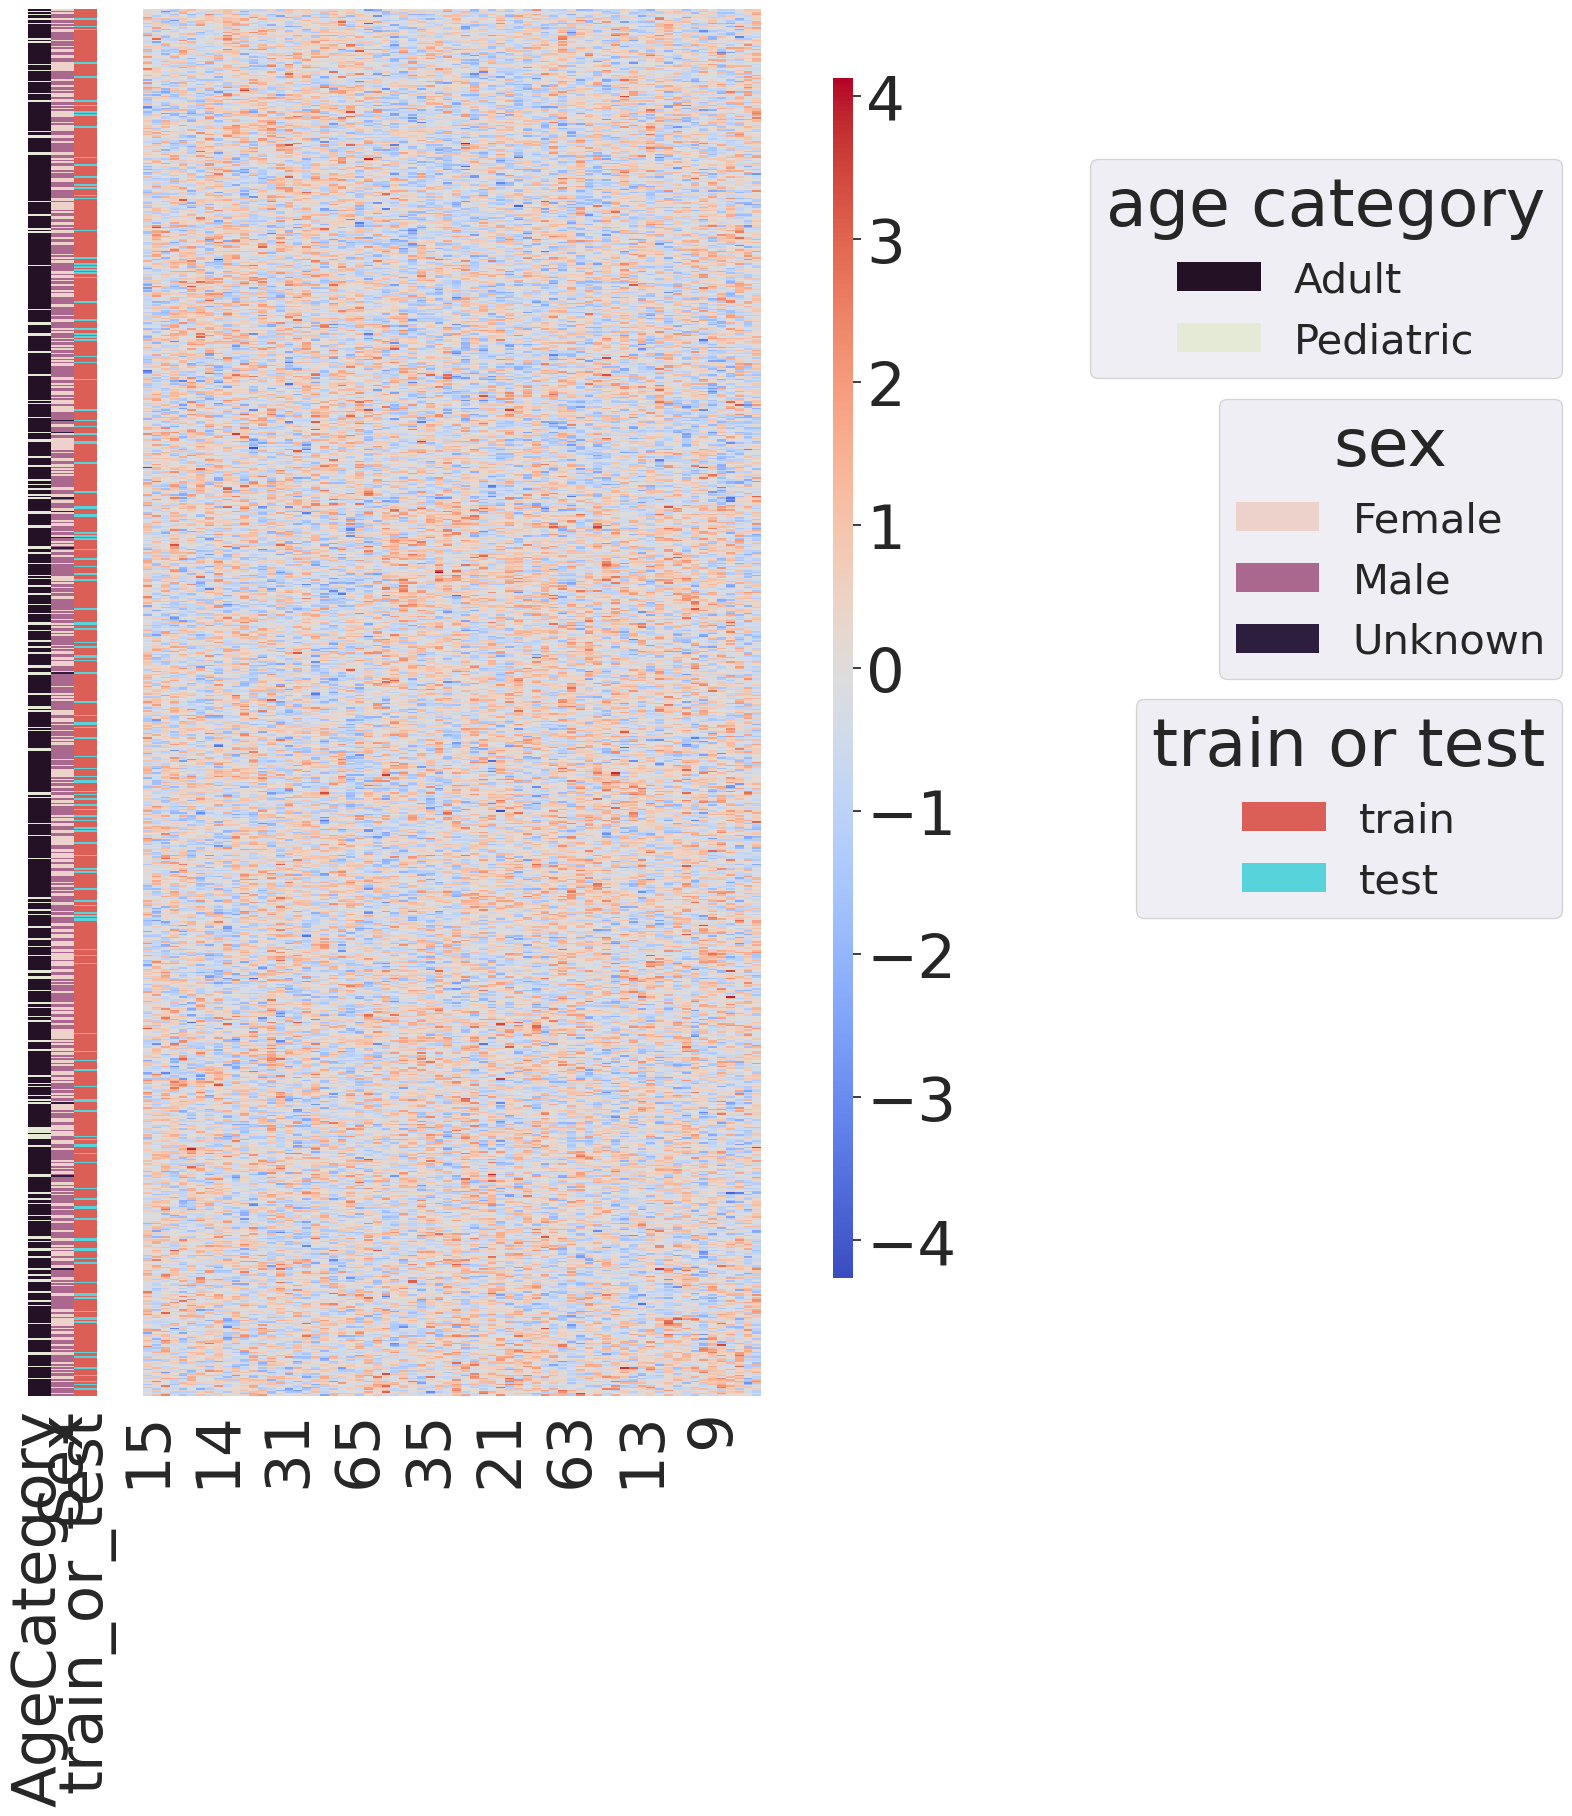

In [10]:
# display clustered heatmap of coefficients
lut_pal = sns.cubehelix_palette(
    AgeCategory.unique().size, light=0.9, dark=0.1, reverse=True, start=1, rot=-2
)
put_pal = sns.cubehelix_palette(Sex.unique().size)
mut_pal = sns.color_palette("hls", train_test.unique().size)

lut = dict(zip(AgeCategory.unique(), lut_pal))
put = dict(zip(Sex.unique(), put_pal))
mut = dict(zip(train_test.unique(), mut_pal))

row_colors1 = AgeCategory.map(lut)
row_colors2 = Sex.map(put)
row_colors3 = train_test.map(mut)

network_node_colors = pd.DataFrame(row_colors1).join(
    pd.DataFrame(row_colors2).join(pd.DataFrame(row_colors3))
)

sns.set(font_scale=4.0)
g = sns.clustermap(
    latent_df.iloc[:,1:],
    method="ward",
    figsize=(10, 20),
    row_colors=network_node_colors,
    yticklabels=False,
    dendrogram_ratio=(0.1, 0.04),
    cbar_pos=(1, 0.3, 0.02, 0.6),
    cmap = "coolwarm",
)
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)


xx = []
for label in AgeCategory.unique():
    x = g.ax_row_dendrogram.bar(0, 0, color=lut[label], label=label, linewidth=0)
    xx.append(x)
# add the legend
legend3 = plt.legend(
    xx,
    AgeCategory.unique(),
    loc="upper right",
    title="age category",
    ncol=1,
    bbox_to_anchor=(1.75, 0.87),
    bbox_transform=gcf().transFigure,
    fontsize = '30'
)


yy = []
for label in Sex.unique():
    y = g.ax_row_dendrogram.bar(0, 0, color=put[label], label=label, linewidth=0)
    yy.append(y)
# add the second legend
legend4 = plt.legend(
    yy,
    Sex.unique(),
    loc="upper right",
    title="sex",
    ncol=1,
    bbox_to_anchor=(1.75, 0.75),
    bbox_transform=gcf().transFigure,
    fontsize = '30'
)
plt.gca().add_artist(legend3)


zz = []
for label in train_test.unique():
    z = g.ax_row_dendrogram.bar(0, 0, color=mut[label], label=label, linewidth=0)
    zz.append(z)
# add the third legend
legend5 = plt.legend(
    zz,
    train_test.unique(),
    loc="upper right",
    title="train or test",
    ncol=1,
    bbox_to_anchor=(1.75, 0.6),
    bbox_transform=gcf().transFigure,
    fontsize = '30'
)
plt.gca().add_artist(legend4)


# save the figure
heat_save_path = pathlib.Path("../1.data-exploration/figures/heatmap.png")
plt.savefig(heat_save_path, bbox_inches="tight", dpi=600)

In [11]:
# load the weights dataframe

gene_weights_df = pd.read_csv("../2.train-VAE/results/weight_matrix_encoder.csv")

gene_weights_df

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
0,-0.034643,-0.018786,0.004884,-0.021371,0.039248,-0.042384,0.032414,0.009567,0.028332,-0.012951,...,0.084094,-0.021814,-0.031163,-0.005313,0.041809,0.015910,0.016175,0.033530,0.023563,0.066336
1,0.030044,0.057998,0.006439,-0.029421,-0.003977,-0.016621,0.021591,-0.019988,-0.063782,-0.045517,...,0.033583,-0.103059,-0.027937,0.012752,0.035559,-0.004912,-0.051767,-0.026627,-0.028017,-0.039394
2,-0.044885,-0.024700,-0.002074,0.011754,-0.042093,0.014245,0.047970,-0.009489,0.011401,-0.057065,...,0.055405,0.004944,-0.051126,0.024678,0.003832,0.008839,-0.028263,0.026857,0.012918,0.028354
3,-0.015553,-0.003088,-0.055477,0.014942,0.029630,0.072798,0.040607,-0.070493,-0.004324,-0.067595,...,0.018114,-0.082460,-0.023459,-0.042566,-0.038063,-0.011956,-0.024815,-0.058613,0.006046,-0.059928
4,0.020240,0.028379,0.008226,0.056760,-0.010616,0.033441,-0.043972,0.062634,-0.037838,-0.007190,...,0.023998,-0.044416,-0.062458,0.005181,0.087309,0.035430,-0.049908,-0.066367,-0.058388,-0.047590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.039177,-0.016013,0.060556,-0.028655,0.059263,-0.022083,0.005846,-0.029584,0.065432,0.036407,...,0.014579,-0.038903,0.067664,-0.078606,-0.001743,-0.013974,-0.046328,-0.008531,0.023867,-0.026778
996,0.073536,-0.027506,-0.056329,-0.005104,-0.062241,-0.034408,0.059089,-0.059330,-0.014620,-0.068750,...,0.025883,-0.074348,0.069595,0.003983,-0.060470,0.063338,0.068501,0.004334,-0.018127,-0.002965
997,-0.045766,-0.012135,-0.015299,-0.009803,0.034820,-0.027053,0.019895,0.004400,-0.028946,-0.027841,...,-0.033012,0.019381,0.080564,0.029072,-0.067050,0.056655,-0.053098,0.051184,-0.047393,-0.048806
998,0.075192,0.054115,-0.026496,0.024400,-0.049650,-0.034899,-0.004914,0.034068,0.008612,0.010923,...,0.050023,0.010291,-0.006104,0.050062,0.065403,0.060108,-0.043805,-0.066282,0.025074,0.052669


/home/ecohen/anaconda3/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


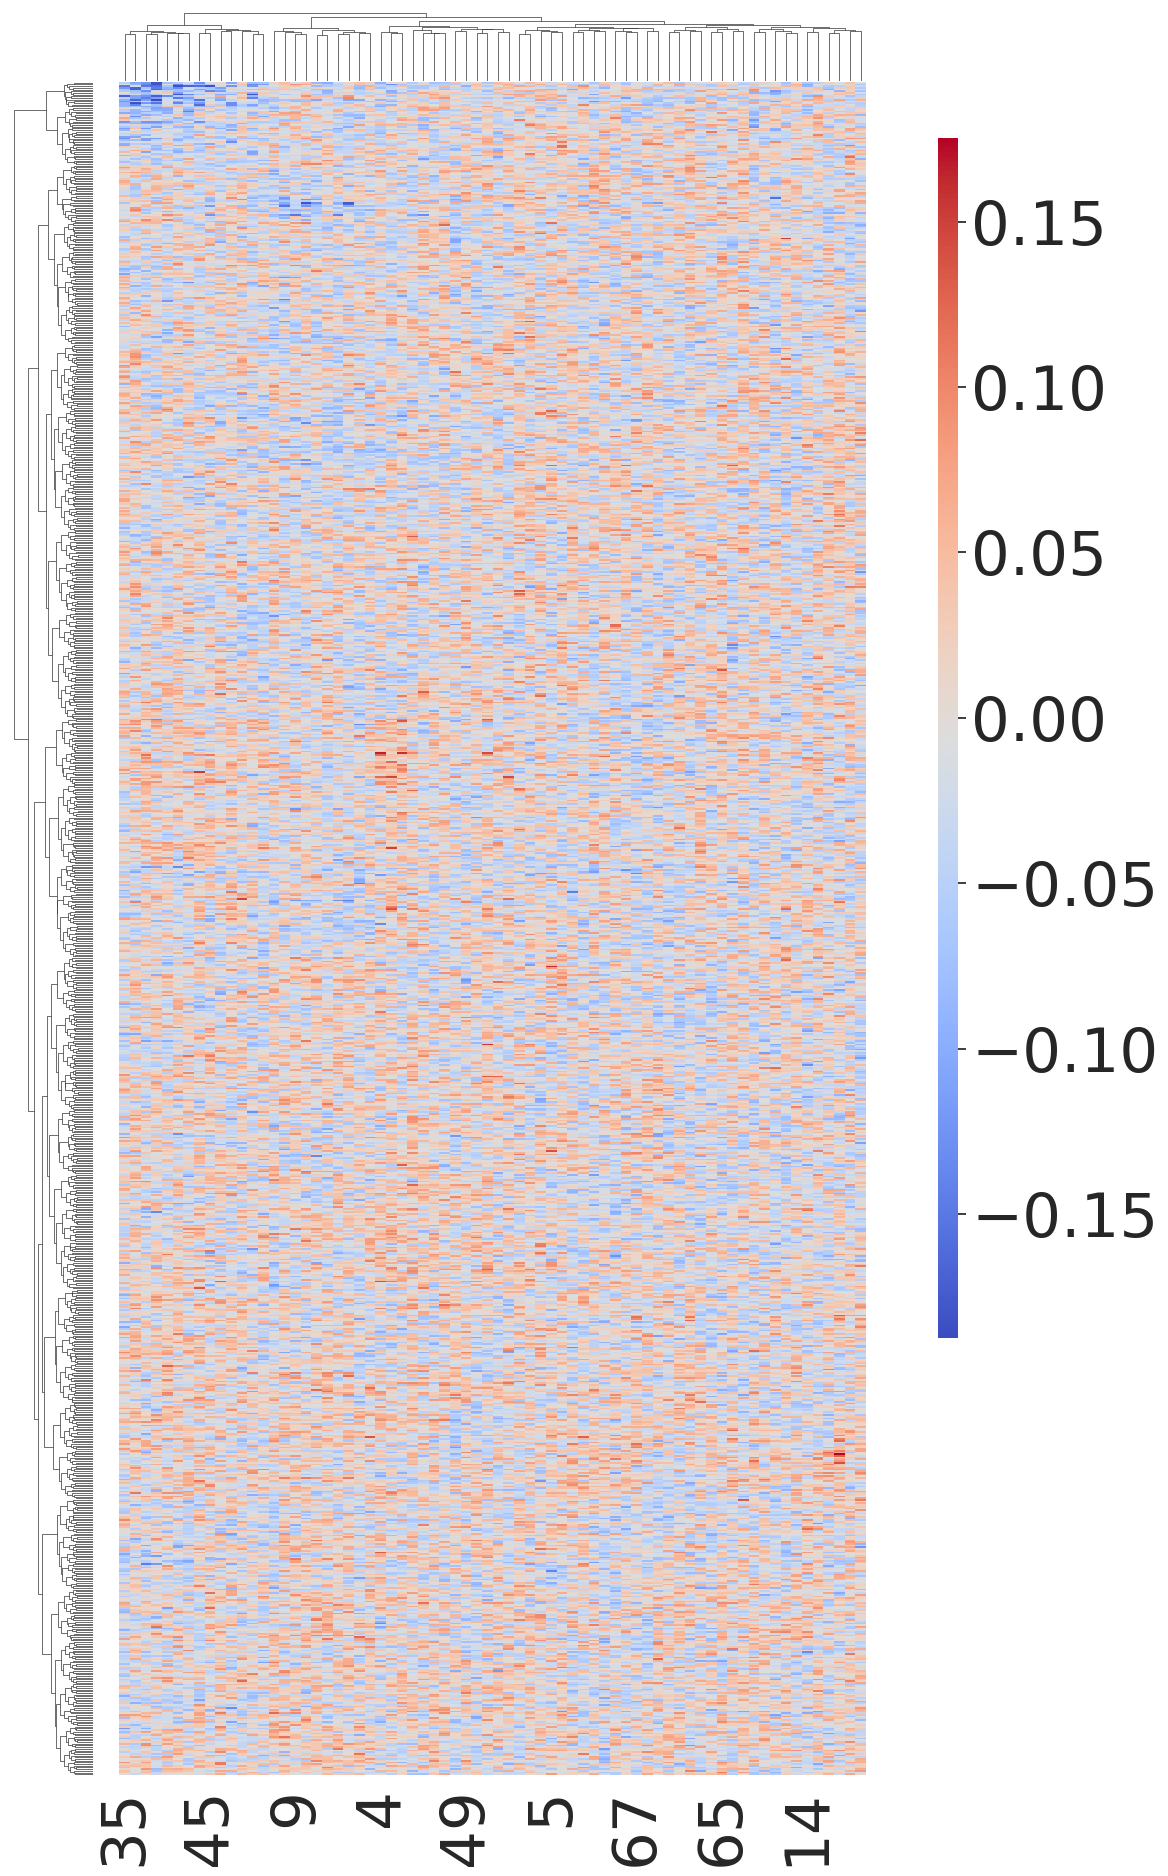

In [12]:
sns.clustermap(
    gene_weights_df,
    method="ward",
    figsize=(10, 20),
    #network_node_colors = pd.DataFrame(row_colors1).join(pd.DataFrame(row_colors2).join(pd.DataFrame(row_colors3))
    #row_colors=network_node_colors,
    yticklabels=False,
    dendrogram_ratio=(0.1, 0.04),
    cbar_pos=(1, 0.3, 0.02, 0.6),
    cmap = "coolwarm",
)
